
# Import Necessary Libraries


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from natsort import natsorted # type: ignore
from sklearn.model_selection import GroupShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.models as models
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import time
from tqdm import tqdm
import torch.profiler
import tkinter as tk
from tkinter import filedialog, messagebox

# Load and Process the CSV File


In [8]:
# Load the CSV file
csv_path = r'C:\Users\Praktikant\Thesis_Hafeez\Dataset\Train_JPEG\ISIC_2020_Training_GroundTruth.csv'# Update with the correct path
df = pd.read_csv(csv_path)

# Inspect the dataframe
print(df.head())
print(df.info())

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null 

In [9]:
# Group by patient_id
grouped = df.groupby('patient_id')['image_name'].apply(list).reset_index()

# Inspect the grouped data
print(grouped.head())

   patient_id                                         image_name
0  IP_0001230  [ISIC_0733981, ISIC_0933821, ISIC_1024677, ISI...
1  IP_0019713  [ISIC_2267785, ISIC_2453557, ISIC_2727309, ISI...
2  IP_0036322  [ISIC_4595555, ISIC_5775708, ISIC_6096977, ISI...
3  IP_0038436         [ISIC_2102371, ISIC_2838960, ISIC_3856233]
4  IP_0038545  [ISIC_0626653, ISIC_1574374, ISIC_1666715, ISI...


#  Split the Dataset into Training and Testing Sets


In [10]:
def split_data(grouped_df, test_size=0.3):
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, test_idx = next(splitter.split(grouped_df, groups=grouped_df['patient_id']))
    train_df = grouped_df.iloc[train_idx]
    test_df = grouped_df.iloc[test_idx]
    return train_df, test_df

# Split the data
train_df, test_df = split_data(grouped)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 1439
Test set size: 617


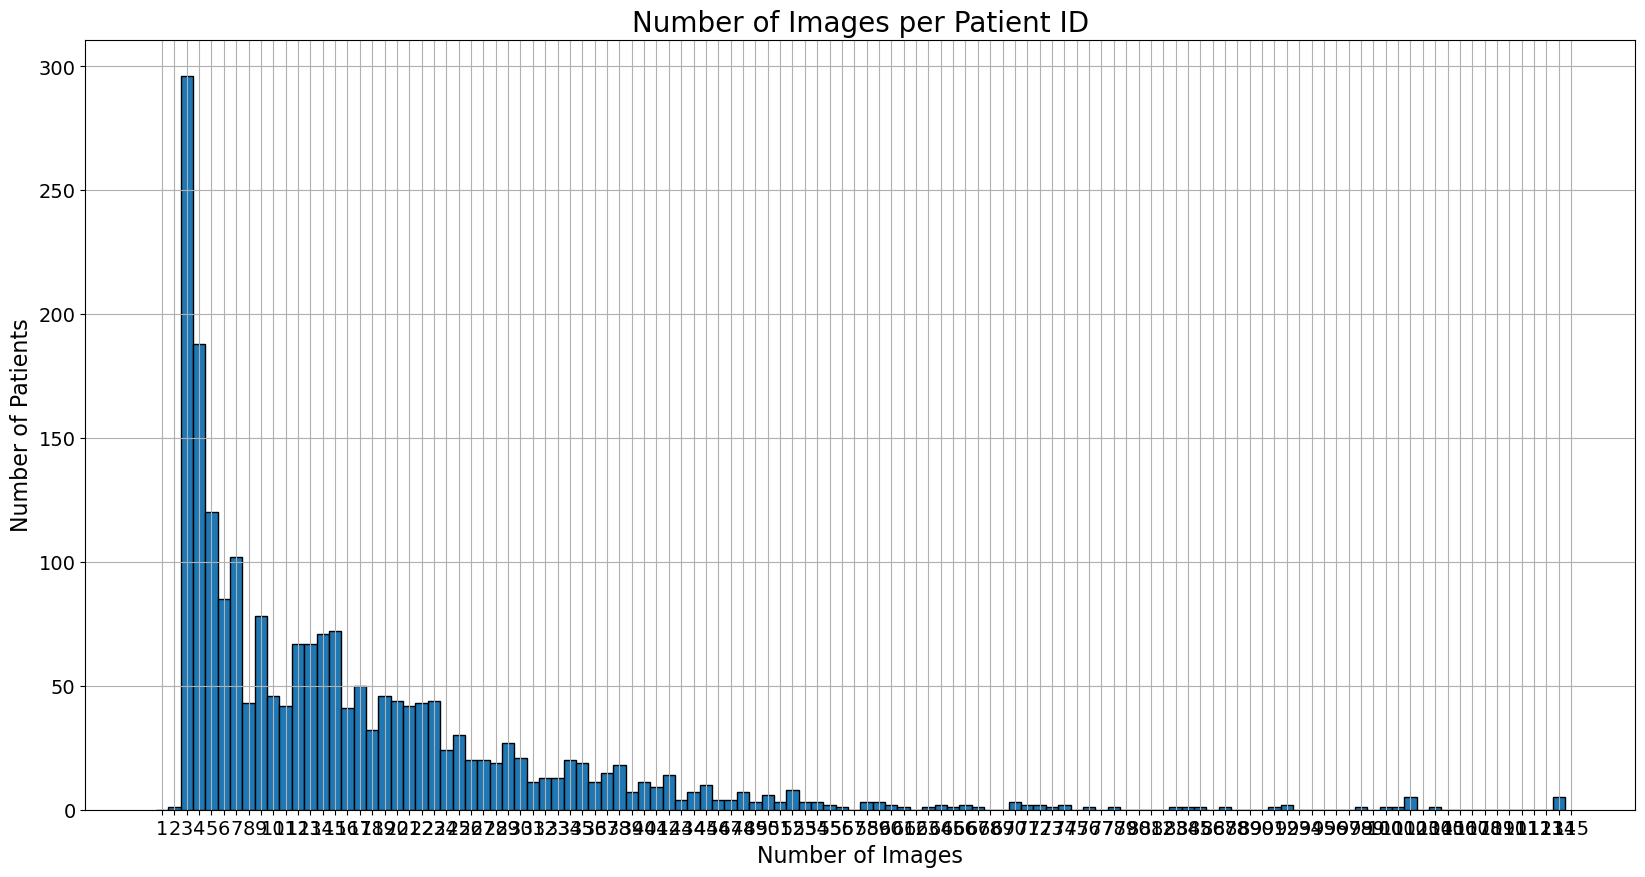

In [11]:
# Load the CSV file
csv_path = r'C:\Users\Praktikant\Thesis_Hafeez\Dataset\Train_JPEG\ISIC_2020_Training_GroundTruth.csv'  # Use raw string
df = pd.read_csv(csv_path)

# Group by patient_id and count the number of images for each patient
image_counts = df.groupby('patient_id').size()

# Plot the histogram for the number of images per patient
plt.figure(figsize=(20, 10))  # Increased figure size for clarity
plt.hist(image_counts, bins=range(1, image_counts.max() + 1), edgecolor='black', align='left')
plt.title('Number of Images per Patient ID', fontsize=20)
plt.xlabel('Number of Images', fontsize=16)
plt.ylabel('Number of Patients', fontsize=16)
plt.xticks(range(1, image_counts.max() + 1), fontsize=14)  # Larger font size for ticks
plt.yticks(fontsize=14)  # Larger font size for y-axis ticks
plt.grid(True)
plt.show()

# Set Initial Parameters

In [14]:
# Learning parameters
INIT_LR = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 64

# Determine if CUDA is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEMORY = True if torch.cuda.is_available() else False

print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


# Define Paths and Create Output Directory


In [15]:
# Paths
CSV_PATH = r'C:\Users\Praktikant\Thesis_Hafeez\Dataset\Train_JPEG\ISIC_2020_Training_GroundTruth.csv'
IMAGE_DIR = r'C:\Users\Praktikant\Thesis_Hafeez\Dataset\Train_JPEG\JPEG'
MODEL_PATH = r'C:\Users\Praktikant\Thesis_Hafeez\Thesis_Code\Enhanced-Skin-Lesion-detection-using-Deep-Learning-model\results\lesion_model.pth'
TEST_PATHS = r'C:\Users\Praktikant\Thesis_Hafeez\Thesis_Code\Enhanced-Skin-Lesion-detection-using-Deep-Learning-model\results'

# Create output directory if it doesn't exist
if not os.path.exists('output'):
    os.makedirs('output')


In [16]:
# Load the CSV file
df = pd.read_csv(CSV_PATH)

# Create a new column with full image paths
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(IMAGE_DIR, f"{x}.jpg"))

# Map labels to binary values
label_encoder = {'benign': 0, 'malignant': 1}
df['label'] = df['benign_malignant'].map(label_encoder)

# Group by patient_id to ensure patient-wise splitting
grouped = df.groupby('patient_id')['image_path'].apply(list).reset_index()

# Sort the image paths for each patient using natsorted
grouped['image_path'] = grouped['image_path'].apply(lambda x: natsorted(x))


# Split the Dataset into Training and Testing Sets

In [17]:
# Use GroupShuffleSplit to split the data patient-wise
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(grouped, groups=grouped['patient_id']))

train_df = grouped.iloc[train_idx]
test_df = grouped.iloc[test_idx]

print(f"[INFO] Training set size: {len(train_df)} patients")
print(f"[INFO] Test set size: {len(test_df)} patients")

# Extract image paths for training and testing
train_image_paths = train_df['image_path'].explode().values.tolist()
test_image_paths = test_df['image_path'].explode().values.tolist()

print(f"[INFO] Number of training images: {len(train_image_paths)}")
print(f"[INFO] Number of testing images: {len(test_image_paths)}")


[INFO] Training set size: 1644 patients
[INFO] Test set size: 412 patients
[INFO] Number of training images: 26161
[INFO] Number of testing images: 6965


# Save Testing Image Paths

In [18]:
# Set the path for saving the test image paths
TEST_PATHS = r'C:\Users\Praktikant\Thesis_Hafeez\Thesis_Code\Enhanced-Skin-Lesion-detection-using-Deep-Learning-model\results\test_image_paths.txt'

print("[INFO] Saving testing image paths...")

# Save the testing image paths
with open(TEST_PATHS, 'w') as f:
    for path in test_image_paths:
        f.write(f"{path}\n")

print(f"[INFO] Testing image paths saved to {TEST_PATHS}")


[INFO] Saving testing image paths...
[INFO] Testing image paths saved to C:\Users\Praktikant\Thesis_Hafeez\Thesis_Code\Enhanced-Skin-Lesion-detection-using-Deep-Learning-model\results\test_image_paths.txt


# Prepare the Dataset

 Define Image Transformations


In [19]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet standards
])


# Create Custom SkinLesion Dataset Class

In [20]:
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, label_dict, transform=None):
        """
        Args:
            image_paths (list): List of image file paths.
            label_dict (dict): Dictionary mapping image paths to labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_paths = image_paths
        self.label_dict = label_dict
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.image_paths[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Get label
        label = self.label_dict[img_path]
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, label


Create Label Dictionary

In [21]:
# Create a mapping from image path to label
label_mapping = df.set_index('image_path')['label'].to_dict()


Initialize Training and Testing Datasets

In [22]:
# Training dataset
train_dataset = SkinLesionDataset(
    image_paths=train_image_paths,
    label_dict=label_mapping,
    transform=transform
)

# Testing dataset
test_dataset = SkinLesionDataset(
    image_paths=test_image_paths,
    label_dict=label_mapping,
    transform=transform
)

print(f"[INFO] Found {len(train_dataset)} examples in the training set...")
print(f"[INFO] Found {len(test_dataset)} examples in the test set...")


[INFO] Found 26161 examples in the training set...
[INFO] Found 6965 examples in the test set...


# Create Data Loaders

In [24]:
trainLoader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=PIN_MEMORY
)

# Testing data loader
testLoader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=PIN_MEMORY
)

#  Define the ResNet Model

In [25]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        # Load a pre-trained ResNet50 model
        self.model = models.resnet50(pretrained=True) 
        
        # Freeze the initial layers if desired
        for param in self.model.parameters():
            param.requires_grad = True  # Set to False to freeze layers
        
        # Replace the final fully connected layer for binary classification
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 1)  # Output is a single logit for binary classification
        
    def forward(self, x):
        return self.model(x)


 # Initialize Model, Loss Function, and Optimizer

In [26]:
# Initialize the model and move it to the appropriate device
model = ResNetModel().to(DEVICE)
model= model.to(DEVICE)

# Define the loss function
lossFunc = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)


c:\Users\Praktikant\AppData\Local\anaconda3\envs\thesis\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Praktikant\AppData\Local\anaconda3\envs\thesis\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Calculate Steps per Epoch

In [27]:
# Calculate steps per epoch
trainSteps = len(trainLoader)
testSteps = len(testLoader)

print(f"[INFO] Training steps per epoch: {trainSteps}")
print(f"[INFO] Testing steps per epoch: {testSteps}")


[INFO] Training steps per epoch: 409
[INFO] Testing steps per epoch: 109


# Initialize Training History Dictionary

In [28]:
# Initialize a dictionary to store training history
H = H = {
    "train_loss": [], "test_loss": [],
    "train_acc": [], "test_acc": [],
    "train_precision": [], "test_precision": [],
    "train_recall": [], "test_recall": [],
    "train_f1": [], "test_f1": []
}


#  Training Loop Implementation with Metric Tracking and Validation

In [29]:
for images, labels in trainLoader:
    print(images.shape, labels.shape)
    break  # Just to check the first batch


In [ ]:

# Start time tracking

startTime = time.time()
 
# Define the profiler

with torch.profiler.profile(

    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),

    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log'),

    record_shapes=True,

    profile_memory=True,

    with_stack=True

) as profiler:

    for epoch in range(NUM_EPOCHS):

        model.train()

        totalTrainLoss, totalTestLoss = 0, 0

        train_preds, train_targets = [], []

        test_preds, test_targets = [], []
 
        print(f"[INFO] Starting Epoch {epoch + 1}/{NUM_EPOCHS}")
 
        # Training Loop with progress bar

        for i, batch in enumerate(tqdm(trainLoader, desc=f"Training Epoch {epoch + 1}")):

            print(f"Processing batch {i+1}/{len(trainLoader)} in training...")

            images, labels = batch

            print(f"Batch {i+1} - images shape: {images.shape}, labels shape: {labels.shape}")

            images, labels = images.to(DEVICE), labels.to(DEVICE)
 
            optimizer.zero_grad()

            outputs = model(images).squeeze()

            loss = lossFunc(outputs, labels.float())

            loss.backward()

            optimizer.step()
 
            totalTrainLoss += loss.item()

            train_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())

            train_targets.extend(labels.cpu().detach().numpy())
 
            # Step the profiler for each batch

            profiler.step()
 
        # Validation Loop with progress bar

        model.eval()

        with torch.no_grad():

            for i, batch in enumerate(tqdm(testLoader, desc=f"Validating Epoch {epoch + 1}")):

                print(f"Processing batch {i+1}/{len(testLoader)} in validation...")

                images, labels = batch

                print(f"Batch {i+1} - images shape: {images.shape}, labels shape: {labels.shape}")

                images, labels = images.to(DEVICE), labels.to(DEVICE)

                outputs = model(images).squeeze()

                loss = lossFunc(outputs, labels.float())
 
                totalTestLoss += loss.item()

                test_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())

                test_targets.extend(labels.cpu().detach().numpy())
 
        # Convert predictions to binary

        train_preds_bin = np.round(train_preds)

        test_preds_bin = np.round(test_preds)
 
        # Calculate average losses

        avgTrainLoss = totalTrainLoss / len(trainLoader)

        avgTestLoss = totalTestLoss / len(testLoader)
 
        # Calculate metrics

        avgTrainAcc = accuracy_score(train_targets, train_preds_bin)

        avgTestAcc = accuracy_score(test_targets, test_preds_bin)

        train_precision = precision_score(train_targets, train_preds_bin)

        test_precision = precision_score(test_targets, test_preds_bin)

        train_recall = recall_score(train_targets, train_preds_bin)

        test_recall = recall_score(test_targets, test_preds_bin)

        train_f1 = f1_score(train_targets, train_preds_bin)

        test_f1 = f1_score(test_targets, test_preds_bin)
 
        # Update history

        H["train_loss"].append(avgTrainLoss)

        H["test_loss"].append(avgTestLoss)

        H["train_acc"].append(avgTrainAcc)

        H["test_acc"].append(avgTestAcc)

        H["train_precision"].append(train_precision)

        H["test_precision"].append(test_precision)

        H["train_recall"].append(train_recall)

        H["test_recall"].append(test_recall)

        H["train_f1"].append(train_f1)

        H["test_f1"].append(test_f1)
 
        # Print the model training and validation information

        print(f"[INFO] EPOCH: {epoch + 1}/{NUM_EPOCHS}")

        print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}")

        print(f"Train Accuracy: {avgTrainAcc:.6f}, Test Accuracy: {avgTestAcc:.4f}")

        print(f"Train Precision: {train_precision:.6f}, Test Precision: {test_precision:.4f}")

        print(f"Train Recall: {train_recall:.6f}, Test Recall: {test_recall:.4f}")

        print(f"Train F1 Score: {train_f1:.6f}, Test F1 Score: {test_f1:.4f}")

        print()
 
# Display the total time needed to perform the training

endTime = time.time()

print(f"[INFO] Total time taken to train the model: {np.round(endTime - startTime)} seconds")

 

# Plot the Metrics 

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(H["train_loss"], label="Train Loss")
plt.plot(H["test_loss"], label="Test Loss")
plt.title("Training and Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(H["train_acc"], label="Train Accuracy")
plt.plot(H["test_acc"], label="Test Accuracy")
plt.title("Training and Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Precision
plt.figure(figsize=(10, 5))
plt.plot(H["train_precision"], label="Train Precision")
plt.plot(H["test_precision"], label="Test Precision")
plt.title("Training and Testing Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(10, 5))
plt.plot(H["train_recall"], label="Train Recall")
plt.plot(H["test_recall"], label="Test Recall")
plt.title("Training and Testing Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 5))
plt.plot(H["train_f1"], label="Train F1 Score")
plt.plot(H["test_f1"], label="Test F1 Score")
plt.title("Training and Testing F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

#serialize the model to disk
torch.save(model, MODEL_PATH)

# Final Model Evaluation on Test Set

In [ ]:
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for batch in testLoader:
        images, labels = batch
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images).squeeze()
        test_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())
        test_targets.extend(labels.cpu().detach().numpy())

# Convert predictions to binary
test_preds_bin = np.round(test_preds)

# Final test metrics
final_test_acc = accuracy_score(test_targets, test_preds_bin)
final_test_precision = precision_score(test_targets, test_preds_bin)
final_test_recall = recall_score(test_targets, test_preds_bin)
final_test_f1 = f1_score(test_targets, test_preds_bin)

print("[INFO] Final Test Accuracy: {:.4f}".format(final_test_acc))
print("[INFO] Final Test Precision: {:.4f}".format(final_test_precision))
print("[INFO] Final Test Recall: {:.4f}".format(final_test_recall))
print("[INFO] Final Test F1 Score: {:.4f}".format(final_test_f1))


# Standard GUI

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk


In [ ]:

# Load the model
model = ResNetModel()
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(DEVICE)))
model.eval()

# Load the ground truth CSV
df = pd.read_csv('path_to_your_ground_truth.csv')

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
# Create a label to display the disclaimer
root = tk.Tk()

disclaimer_label = tk.Label(root, text="Please select images from the same patient for accurate results.", font=("Arial", 12), bg="#f5f5f5", fg="red")
disclaimer_label.pack(pady=10)

In [ ]:

# Define a function to load and predict images
def select_images():
    file_paths = filedialog.askopenfilenames(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if not file_paths:
        return
    
    # Display selected images
    for widget in image_frame.winfo_children():
        widget.destroy()
    
    images = []
    for file_path in file_paths:
        img = Image.open(file_path)
        img.thumbnail((150, 150))
        img = ImageTk.PhotoImage(img)
        img_label = tk.Label(image_frame, image=img)
        img_label.image = img  # Keep a reference to avoid garbage collection
        img_label.pack(side="left", padx=10)
        images.append(file_path)
    
    predict_images(images)

# Predict whether the selected images are malignant or benign
def predict_images(image_paths):
    predictions = []
    correct_preds = 0

    for path in image_paths:
        img = Image.open(path)
        img_tensor = transform(img).unsqueeze(0)
        with torch.no_grad():
            output = model(img_tensor).item()
            prediction = "Malignant" if output >= 0.5 else "Benign"
            predictions.append((path, prediction))
        
        # Cross-verify with ground truth
        image_id = os.path.basename(path)
        ground_truth = df[df['image_name'] == image_id]['target'].values[0]
        correct_label = "Malignant" if ground_truth == 1 else "Benign"
        
        if prediction == correct_label:
            correct_preds += 1
    
    # Display results
    result_text = ""
    for i, (path, pred) in enumerate(predictions):
        result_text += f"Image {i+1}: {os.path.basename(path)} - Predicted: {pred}\n"

    accuracy = (correct_preds / len(predictions)) * 100
    result_text += f"\nOverall Accuracy: {accuracy:.2f}%\n"

    if len(set(df['patient_id'][df['image_name'].isin([os.path.basename(p) for p in image_paths])])) > 1:
        result_text += "\nDisclaimer: Selected images belong to different patients. Results may not be accurate."

    result_label.config(text=result_text)

# Create a frame for displaying images
image_frame = tk.Frame(root, bg="#f5f5f5")
image_frame.pack(pady=20)

# Create a button for selecting images
select_button = tk.Button(root, text="Select Images", command=select_images, font=("Arial", 14), bg="#4CAF50", fg="white")
select_button.pack(pady=10)

# Create a label to display the results
result_label = tk.Label(root, text="", font=("Arial", 12), bg="#f5f5f5", justify="left")
result_label.pack(pady=20)


In [ ]:

# Start the GUI loop
root.mainloop()